In [2]:
#Mid term

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.graphics.tsaplots import plot_acf # import this function from this submodule
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import gaussian_kde, norm, iqr, skew, kurtosis, jarque_bera, kstest, anderson
from statsmodels.stats.diagnostic import lilliefors
import scipy.signal as ss
import pylab

In [127]:
#As a sample we are going to take APPL between 1995 and 2023
#Stock market= Euronext Paris; France
start= "1995-01-01"
end= "2023-12-31"
tickers= "AAPL"
stock = yf.download(tickers, start, end)
stock

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-01-03,0.347098,0.347098,0.338170,0.342634,0.285766,103868800
1995-01-04,0.344866,0.353795,0.344866,0.351563,0.293213,158681600
1995-01-05,0.350446,0.351563,0.345982,0.347098,0.289489,73640000
1995-01-06,0.371652,0.385045,0.367188,0.375000,0.312760,1076622400
1995-01-09,0.371652,0.373884,0.366071,0.367885,0.306826,274086400
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,192.656189,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.108856,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.208359,48087700


In [5]:
#Lenght of our sample
#dayly
D=len(stock)
print(D)
#monthly
M=len(stock.resample('M'))
print(M)

#annualy
A=len(stock.resample('A'))
A

7300
348


29

In [6]:
#We look at closing prices
stock_adj = stock["Adj Close"]
stock_adj

Date
1995-01-03      0.285766
1995-01-04      0.293213
1995-01-05      0.289489
1995-01-06      0.312760
1995-01-09      0.306826
                 ...    
2023-12-22    192.656189
2023-12-26    192.108856
2023-12-27    192.208359
2023-12-28    192.636276
2023-12-29    191.591385
Name: Adj Close, Length: 7300, dtype: float64

In [7]:
#Compute log prices
log_stock_adj = np.log(stock_adj)

In [8]:
#Daily log prices
stock_adj_d = log_stock_adj
#Monthly log prices
stock_adj_m = log_stock_adj.resample('M').last()
#Yearly log prices
stock_adj_a = log_stock_adj.resample('A').last()

In [9]:
#Daily log returns
rd = stock_adj_d.diff().dropna() #We remove Null
#Monthly log returns
rm = stock_adj_m.diff().dropna()
#Yearly log returns
ra = stock_adj_a.diff().dropna()
ra

Date
1996-12-31   -0.423269
1997-12-31   -0.464030
1998-12-31    1.137523
1999-12-31    0.920861
2000-12-31   -1.240078
2001-12-31    0.386804
2002-12-31   -0.424130
2003-12-31    0.399632
2004-12-31    1.103126
2005-12-31    0.803171
2006-12-31    0.165630
2007-12-31    0.847904
2008-12-31   -0.841911
2009-12-31    0.903817
2010-12-31    0.425712
2011-12-31    0.227598
2012-12-31    0.281917
2013-12-31    0.077605
2014-12-31    0.340909
2015-12-31   -0.030601
2016-12-31    0.117609
2017-12-31    0.395175
2018-12-31   -0.055409
2019-12-31    0.636354
2020-12-31    0.600520
2021-12-31    0.297495
2022-12-31   -0.306582
2023-12-31    0.398830
Freq: A-DEC, Name: Adj Close, dtype: float64

In [10]:
#We put the dates in date type
start_date = pd.to_datetime(start)
end_date = pd.to_datetime(end)

In [11]:
# Select the interval using loc (only for pandas series)
Pt_d = stock_adj.loc[start_date:end_date]
pt_d = stock_adj_d.loc[start_date:end_date]
pt_m = stock_adj_m.loc[start_date:end_date]
pt_y = stock_adj_a.loc[start_date:end_date]
rt_d = rd.loc[start_date:end_date]
rt_m = rm.loc[start_date:end_date]
rt_y = ra.loc[start_date:end_date]

In [13]:
# X contains returns at different frequencies
X = {
    'daily': rt_d,
    'monthly': rt_m,
    'annual': rt_y
}

In [14]:
def multi_fun(x):
    stat_tab = {
        'Mean': round(np.mean(x) * 100,5),
        'St.Deviation': round(np.std(x) * 100,5),
        'Diameter.C.I.Mean': round(1.96 * np.sqrt(np.var(x) / len(x)) * 100,5),
        'Skewness': round(skew(x),5),
        'Kurtosis': round(kurtosis(x),5),
        'Excess.Kurtosis': round(kurtosis(x) - 3,5),
        'Min': round(np.min(x) * 100,5),
        'Quant5': round(np.quantile(x, 0.05) * 100,5),
        'Quant25': round(np.quantile(x, 0.25) * 100,5),
        'Median': round(np.quantile(x, 0.50) * 100,5),
        'Quant75': round(np.quantile(x, 0.75) * 100,5),
        'Quant95': round(np.quantile(x, 0.95) * 100,5),
        'Max': round(np.max(x) * 100,5),
        'Jarque.Bera.stat': round(jarque_bera(x)[0],5),
        'Jarque.Bera.pvalue.X100': round(jarque_bera(x)[1] *100,5),
        'Lillie.test.stat': round(lilliefors(x)[0],5),
        'Lillie.test.pvalue.X100': round(lilliefors(x)[1] * 100,5),
        'N.obs': len(x)
    }
    return stat_tab 
multi_fun(rt_d)

{'Mean': 0.08916,
 'St.Deviation': 2.74356,
 'Diameter.C.I.Mean': 0.06294,
 'Skewness': -2.42952,
 'Kurtosis': 75.05436,
 'Excess.Kurtosis': 72.05436,
 'Min': -73.12477,
 'Quant5': -3.95365,
 'Quant25': -1.12633,
 'Median': 0.06938,
 'Quant75': 1.357,
 'Quant95': 4.09192,
 'Max': 28.68921,
 'Jarque.Bera.stat': 1720364.1503,
 'Jarque.Bera.pvalue.X100': 0.0,
 'Lillie.test.stat': 0.08184,
 'Lillie.test.pvalue.X100': 0.1,
 'N.obs': 7299}

In [15]:
# 1. 
statistics_dict = {}

# 2.
statistics_dict = {
    key: multi_fun(data.iloc[1:]) 
    for key, data in X.items()
}
statistics_df = pd.DataFrame(statistics_dict) #transform a dictionnary in a table
print(statistics_df)


                                daily    monthly     annual
Mean                     8.882000e-02    1.87177   26.31648
St.Deviation             2.743600e+00   12.24779   55.65865
Diameter.C.I.Mean        6.295000e-02    1.29055   20.99456
Skewness                -2.429500e+00   -1.36590   -0.73858
Kurtosis                 7.505989e+01    7.67936    0.43453
Excess.Kurtosis          7.205989e+01    4.67936   -2.56547
Min                     -7.312477e+01  -86.14152 -124.00780
Quant5                  -3.953710e+00  -16.70060  -72.85463
Quant25                 -1.126350e+00   -4.24320    2.35020
Median                   6.907000e-02    2.84505   34.09087
Quant75                  1.356390e+00    9.40473   61.84370
Quant95                  4.092040e+00   19.29212  104.84465
Max                      2.868921e+01   37.41689  113.75225
Jarque.Bera.stat         1.720381e+06  957.77505    2.66714
Jarque.Bera.pvalue.X100  0.000000e+00    0.00000   26.35342
Lillie.test.stat         8.192000e-02   

In [15]:
#stylized fact 1: Prices ar non-stationary
#On montre que pas weak stationaritty donc pas stationnaire
#Mettre pour les trois frequances à chaque fois
#Voir si mettre histogram of daily pricees and normal density

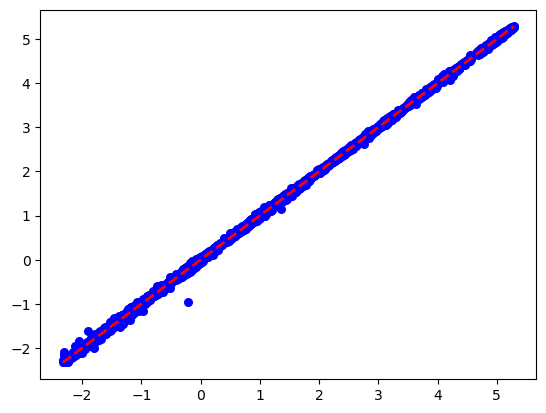

In [16]:
# pt en fonction de pt-1 meilleur prediction des prix est le prix precedent
def lag1_scatterplot(data, x_label, y_label, title):
    plt.scatter(data.shift(), data, color='blue', s=30)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot([min(data), max(data)], [min(data), max(data)], linestyle='dashed', linewidth=2, color='red')
# run the function for the log-prices
lag1_scatterplot(pt_d,"","","")

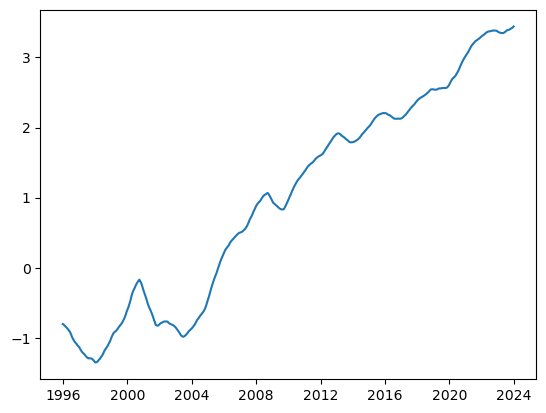

In [17]:
#esperance depend du temps avec moyenne roulante (pas independante de t)
def pourcentage_moyenne_roulante(data,N):
    moyenne_data= np.mean(data)
    y=[]
    x=[]
    for i in range(len(data)-N):
        y.append(np.mean(data[i:N+i])/moyenne_data)
        x.append(data.index[i + N - 1])
    plt.plot(x,y)
    plt.show()
    
pourcentage_moyenne_roulante(pt_d,252)
    

/var/folders/4k/8h7kzppn7yz3wvf566hj8yhw0000gn/T/ipykernel_77692/3496520168.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = pt_d[est_window]


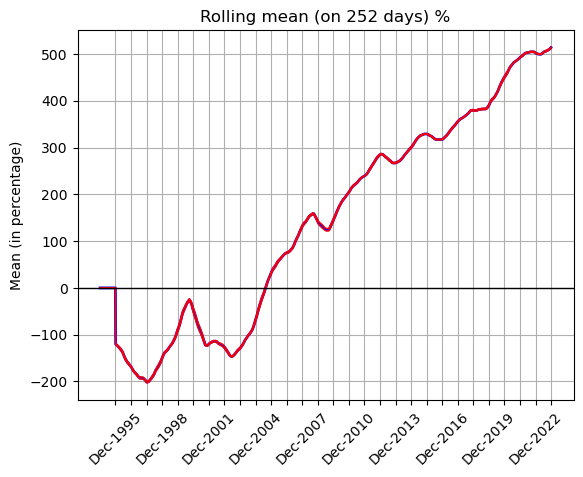

In [120]:
#Prices rolling mean
# set the rolling window equal to 252 days
window_length = 252
T = pt_d.shape[0]

# Create an empty matrix to store data
roll_mom_manual = np.zeros((T, 5))

# Run a for loop to fill the matrix with moments
for i in range(window_length, T):
    est_window = np.arange(i - window_length + 1, i + 1)
    y = pt_d[est_window]
    # compute the moments for each 
    roll_mom_manual[i, 0] = np.mean(y)
    roll_mom_manual[i, 1] = np.std(y, ddof=1)
    roll_mom_manual[i, 2] = skew(y)
    roll_mom_manual[i, 3] = kurtosis(y)
    roll_mom_manual[i, 4] = np.mean((y - np.mean(y))**4)

# Plot results of manually computed rolling mean
mean_plot_man = roll_mom_manual[:, 0]
mean_plot_man_ub = mean_plot_man + 1.96 * roll_mom_manual[:, 1] / np.sqrt(window_length)
mean_plot_man_lb = mean_plot_man - 1.96 * roll_mom_manual[:, 1] / np.sqrt(window_length)

data2plot_na = np.column_stack((mean_plot_man, mean_plot_man_lb, mean_plot_man_ub))
data_index = pt_d.index
data2plot_na = pd.DataFrame({'Mean': mean_plot_man, 'LowerBound': mean_plot_man_lb, 'UpperBound': mean_plot_man_ub},
                               index=data_index)

# Select only rows without missing values
data2plot = data2plot_na.dropna()
# retrieve the data index
data2plot

# Customizing x-axis labels for December 31 of each year
date_labels = pd.date_range(start, end, freq='A-DEC')
# Show 1 tick every 3 years
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
# Add labels and rotate them 
plt.xticks(date_labels, formatted_labels, rotation=45)

# Plot the data
plt.plot(data2plot.index, data2plot["Mean"] * 100, color='blue', linestyle='-', linewidth=2)
plt.plot(data2plot.index, data2plot["LowerBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["UpperBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.grid(True)
plt.xlabel('')
plt.ylabel('Mean (in percentage)')
plt.title('Rolling mean (on 252 days) %')
plt.axhline(0, linestyle='-', color='black', linewidth=1)  # Add a zero line
plt.show()

In [ ]:

def pourcentage_variance_roulante(data,N):
    y=[]
    x=[]
    std_data=np.std(data)

    for i in range(len(data)-N):
        y.append(np.std(data[i:N+i])/std_data)
        x.append(data.index[i + N - 1])
    plt.plot(x,y)
    plt.show()
    
pourcentage_variance_roulante(pt_d,252)

In [60]:
#autocorrelation on voit bien que depnd du temps (diminue)
autocorr = pt_d.shift().corr(pt_d, method='pearson')
print("Lag 1: autocorrelation = ", round(autocorr,3))

Lag 1: autocorrelation =  1.0


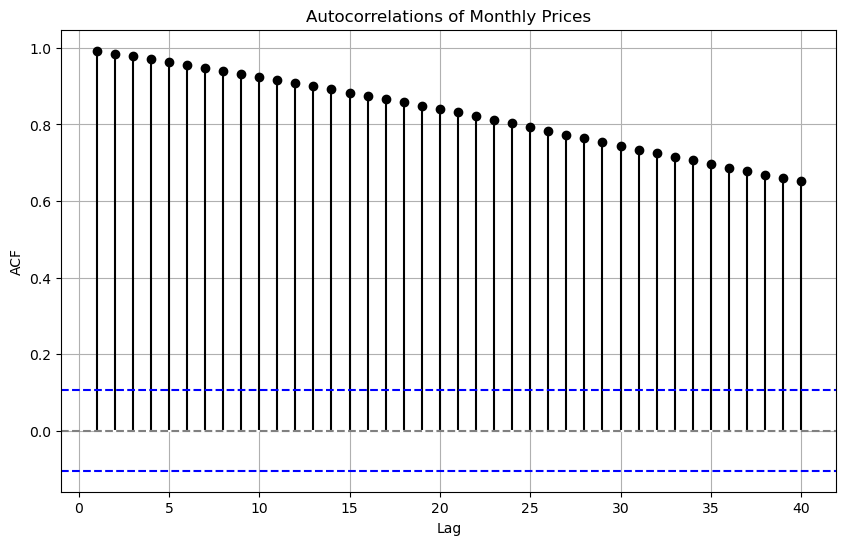

In [122]:
from statsmodels.tsa.stattools import acf
#very strong autocorelation prices

# Calculate empirical autocorrelation
lags = 40
acf_values = acf(pt_m, nlags=lags)

# Calculate Bartlett intervals
Bart_Int = 1.96 / np.sqrt(len(pt_m))

# Create the autocorrelation plot with Bartlett intervals
plt.figure(figsize=(10, 6))
plt.stem(np.arange(1, lags + 1), acf_values[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
plt.axhline(y=0, color='gray', linestyle='--')
plt.axhline(y=Bart_Int, color='blue', linestyle='--')
plt.axhline(y=-Bart_Int, color='blue', linestyle='--')
plt.title('Autocorrelations of Monthly Prices')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.grid(True)

plt.show()

In [ ]:
#stylized fact 2: returns are stationnary
#second order stationarity
#skewness and kurtosis à peut etre montrer

In [ ]:
#daily log returns

/var/folders/4k/8h7kzppn7yz3wvf566hj8yhw0000gn/T/ipykernel_77692/3717740083.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = rt_d[est_window]


DatetimeIndex(['1995-01-04', '1995-01-05', '1995-01-06', '1995-01-09',
               '1995-01-10', '1995-01-11', '1995-01-12', '1995-01-13',
               '1995-01-16', '1995-01-17',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=7299, freq=None) Date
1995-01-04    0.000000
1995-01-05    0.000000
1995-01-06    0.000000
1995-01-09    0.000000
1995-01-10    0.000000
                ...   
2023-12-22    0.143955
2023-12-26    0.152373
2023-12-27    0.153691
2023-12-28    0.160119
2023-12-29    0.170328
Name: Mean, Length: 7299, dtype: float64


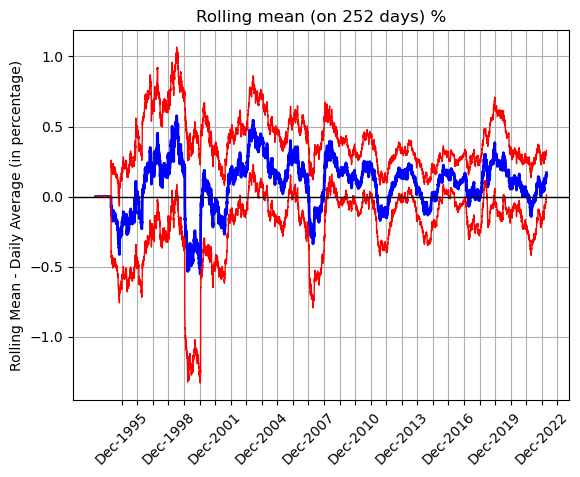

In [108]:
# set the rolling window equal to 252 days
window_length = 252
T = rt_d.shape[0]
# Create an empty matrix to store data
roll_mom_manual = np.zeros((T, 5))

# Run a for loop to fill the matrix with moments
for i in range(window_length, T):
    est_window = np.arange(i - window_length + 1, i + 1)
    y = rt_d[est_window]
    # compute the moments for each 
    roll_mom_manual[i, 0] = np.mean(y)
    roll_mom_manual[i, 1] = np.std(y, ddof=1)
    roll_mom_manual[i, 2] = skew(y)
    roll_mom_manual[i, 3] = kurtosis(y)+3
    roll_mom_manual[i, 4] = np.mean((y - np.mean(y))**4)

# Plot results of manually computed rolling mean
mean_plot_man = roll_mom_manual[:, 0]
mean_plot_man_ub = mean_plot_man + 1.96 * roll_mom_manual[:, 1] / np.sqrt(window_length)
mean_plot_man_lb = mean_plot_man - 1.96 * roll_mom_manual[:, 1] / np.sqrt(window_length)

data2plot_na = np.column_stack((mean_plot_man, mean_plot_man_lb, mean_plot_man_ub))
data_index = rt_d.index
data2plot_na = pd.DataFrame({'Mean': mean_plot_man, 'LowerBound': mean_plot_man_lb, 'UpperBound': mean_plot_man_ub},
                               index=data_index)

# Select only rows without missing values
data2plot = data2plot_na.dropna()
# retrieve the data index
data2plot

# Customizing x-axis labels for December 31 of each year
date_labels = pd.date_range(start, end, freq='A-DEC')
# Show 1 tick every 3 years
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
# Add labels and rotate them 
plt.xticks(date_labels, formatted_labels, rotation=45)
print(data2plot.index, data2plot["Mean"] * 100)
data2plot.index = data2plot.index - pd.DateOffset(window_length)
# Plot the data
plt.plot(data2plot.index, data2plot["Mean"] * 100, color='blue', linestyle='-', linewidth=2)
plt.plot(data2plot.index, data2plot["LowerBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["UpperBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.grid(True)
plt.xlabel('')
plt.ylabel('Rolling Mean - Daily Average (in percentage)')
plt.title('Rolling mean (on 252 days) %')
plt.axhline(0, linestyle='-', color='black', linewidth=1)  # Add a zero line

plt.show()

/var/folders/4k/8h7kzppn7yz3wvf566hj8yhw0000gn/T/ipykernel_77692/933587809.py:4: RuntimeWarning: divide by zero encountered in divide
  sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
/var/folders/4k/8h7kzppn7yz3wvf566hj8yhw0000gn/T/ipykernel_77692/933587809.py:4: RuntimeWarning: invalid value encountered in multiply
  sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
/var/folders/4k/8h7kzppn7yz3wvf566hj8yhw0000gn/T/ipykernel_77692/933587809.py:5: RuntimeWarning: divide by zero encountered in divide
  sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
/var/folders/4k/8h7kzppn7yz3wvf566hj8yhw0000gn/T/ipykernel_77692/933587809.py:5: RuntimeWarning: invalid value encountered in multiply
  sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)


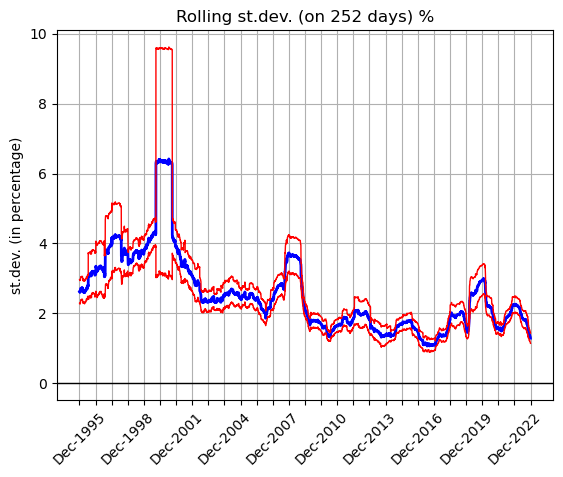

In [107]:
# extract the Std Dev from roll_mom_manual
sd_plot = roll_mom_manual[:,1]
mu4 = roll_mom_manual[:,4]
sd_plot_ub = roll_mom_manual[:,1]+1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)
sd_plot_lb = roll_mom_manual[:,1]-1.96*(1/(2*sd_plot)*np.sqrt(mu4-sd_plot**4))/np.sqrt(window_length)

data2plot_na = np.column_stack((sd_plot, sd_plot_lb, sd_plot_ub))

data_index = rt_d.index

data2plot_na = pd.DataFrame({'StD': sd_plot, 'LowerBound': sd_plot_lb, 'UpperBound': sd_plot_ub},
                               index=data_index)

# Select only rows without missing values
data2plot = data2plot_na.dropna()
# retrieve the data index
data2plot

# Customizing x-axis labels for December 31 of each year
date_labels = pd.date_range(start, end, freq='A-DEC')
# Show 1 tick every 3 years
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
# Add labels and rotate them 
plt.xticks(date_labels, formatted_labels, rotation=45)

# Plot the data
plt.plot(data2plot.index, data2plot["StD"] * 100, color='blue', linestyle='-', linewidth=2)
plt.plot(data2plot.index, data2plot["LowerBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["UpperBound"] * 100, color='red', linestyle='-', linewidth=1)
plt.xlabel('')
plt.grid(True)
plt.ylabel('st.dev. (in percentage)')
plt.title('Rolling st.dev. (on 252 days) %')
plt.axhline(0, linestyle='-', color='black', linewidth=1)  # Add a zero line

plt.show()

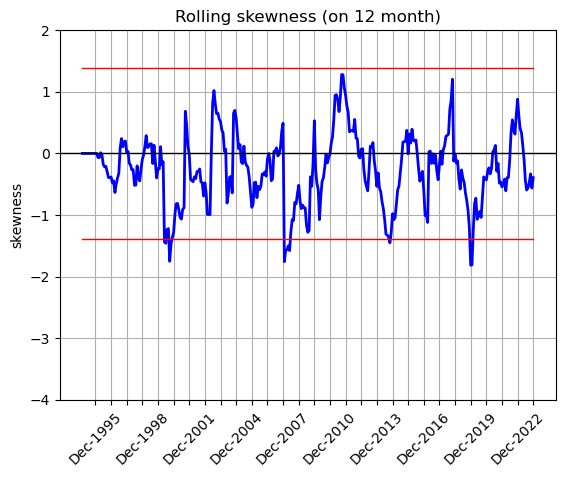

In [104]:
# Skewess
skew_plot = roll_mom_manual[:,2]
skew_plot_ub = np.full(skew_plot.shape[0],+1.96*np.sqrt(6)/np.sqrt(window_length))
skew_plot_lb = np.full(skew_plot.shape[0],-1.96*np.sqrt(6)/np.sqrt(window_length))

data2plot_na = np.column_stack((skew_plot, skew_plot_lb, skew_plot_ub))

data_index = rt_m.index

data2plot_na = pd.DataFrame({'Skewness': skew_plot, 'LowerBound': skew_plot_lb, 'UpperBound': skew_plot_ub},
                               index=data_index)

# Select only rows without missing values
data2plot = data2plot_na.dropna()
# retrieve the data index
data2plot

# Customizing x-axis labels for December 31 of each year
date_labels = pd.date_range(start, end, freq='A-DEC')
# Show 1 tick every 3 years
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
# Add labels and rotate them 
plt.xticks(date_labels, formatted_labels, rotation=45)

# Plot the data
plt.plot(data2plot.index, data2plot["Skewness"], color='blue', linestyle='-', linewidth=2)
plt.plot(data2plot.index, data2plot["LowerBound"], color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["UpperBound"], color='red', linestyle='-', linewidth=1)
plt.ylim(-4,2)
plt.grid(True)
plt.xlabel('')
plt.ylabel('skewness')
plt.title('Rolling skewness (on 12 month)')
plt.axhline(0, linestyle='-', color='black', linewidth=1)  # Add a zero line

plt.show()


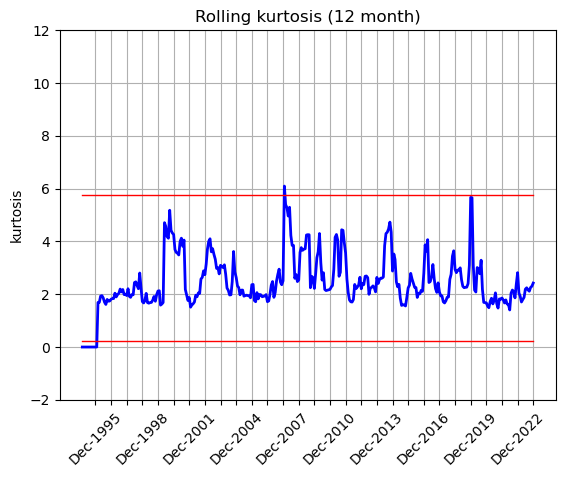

In [100]:
# Kurtosis
kurt_plot = roll_mom_manual[:,3]
kurt_plot_ub = np.full(skew_plot.shape[0],3+1.96*np.sqrt(24)/np.sqrt(window_length))
kurt_plot_lb = np.full(skew_plot.shape[0],3-1.96*np.sqrt(24)/np.sqrt(window_length))

data2plot_na = np.column_stack((kurt_plot, kurt_plot_lb, kurt_plot_ub))

data_index = rt_m.index

data2plot_na = pd.DataFrame({'Kurtosis': kurt_plot, 'LowerBound': kurt_plot_lb, 'UpperBound': kurt_plot_ub},
                               index=data_index)

# Select only rows without missing values
data2plot = data2plot_na.dropna()
# retrieve the data index
data2plot

# Customizing x-axis labels for December 31 of each year
date_labels = pd.date_range(start, end, freq='A-DEC')
# Show 1 tick every 3 years
formatted_labels = [f'Dec-{date.year}' if date.year % 3 == 0 else '' for date in date_labels]
# Add labels and rotate them 
plt.xticks(date_labels, formatted_labels, rotation=45)

# Plot the data
plt.plot(data2plot.index, data2plot["Kurtosis"], color='blue', linestyle='-', linewidth=2)
plt.plot(data2plot.index, data2plot["LowerBound"], color='red', linestyle='-', linewidth=1)
plt.plot(data2plot.index, data2plot["UpperBound"], color='red', linestyle='-', linewidth=1)
plt.ylim(-2,12)
plt.grid(True)
plt.xlabel('')
plt.ylabel('kurtosis')
plt.title('Rolling kurtosis (12 month)')

plt.show()

In [59]:
pourcentage_variance_roulante(rt_d,252)

NameError: name 'pourcentage_variance_roulante' is not defined

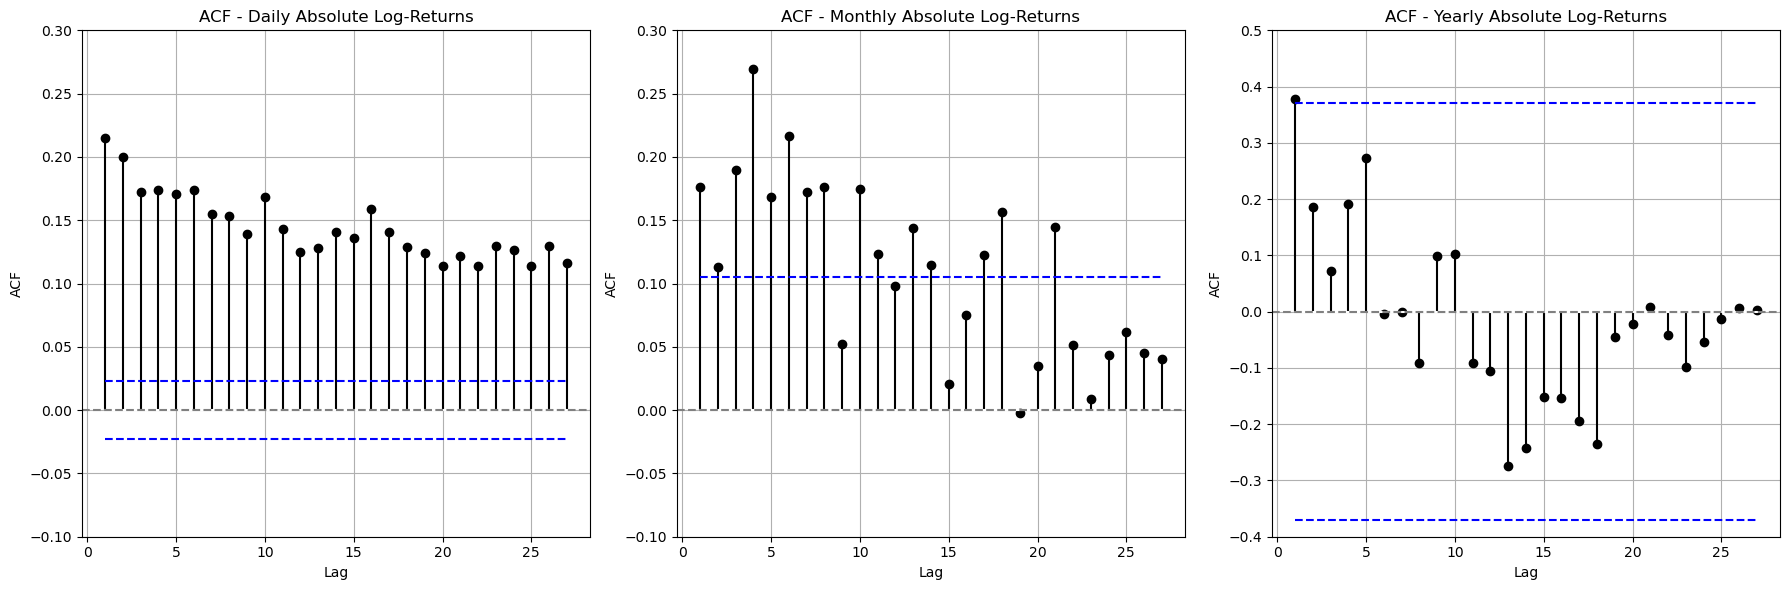

In [64]:
# Compute the empirical ACF (abs)
lags = 27
acf_values_daily = acf(abs(rt_d), nlags=lags)
# Compute the bartlet intervals
confint = 1.96 / np.sqrt(len(rt_d))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)
# Set the layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# ACF of daily log-returns
axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.1, 0.3)
axs[0].set_title('ACF - Daily Absolute Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)
# ACF of abs monthly log-returns
acf_values_monthly = acf(abs(rt_m), nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_m))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)
axs[1].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.1, 0.3)
axs[1].set_title('ACF - Monthly Absolute Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)
# ACF of abs Yearly log-returns
acf_values_yearly = acf(abs(rt_y), nlags=lags)
confint_yearly = 1.96 / np.sqrt(len(rt_y))
confint_yearly_upper = np.full(lags, confint_yearly)
confint_yearly_lower = -np.full(lags, confint_yearly)
axs[2].stem(np.arange(1, lags + 1), acf_values_yearly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, lags + 1), confint_yearly_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, lags + 1), confint_yearly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.4, 0.5)
axs[2].set_title('ACF - Yearly Absolute Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)
# Set the space
plt.tight_layout()
plt.show()

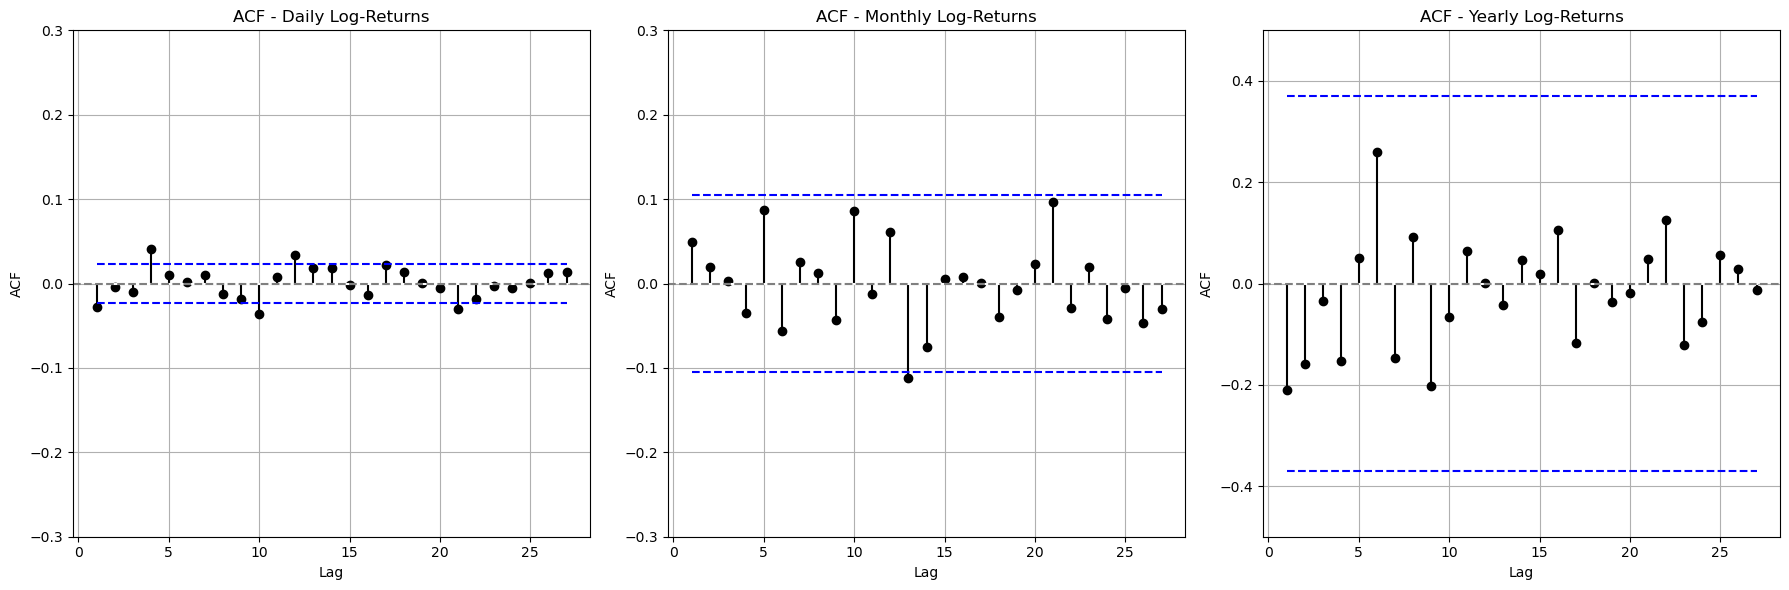

In [118]:
# Compute the empirical ACF
lags = 27
acf_values_daily = acf(rt_d, nlags=lags)
# Compute the bartlet intervals
confint = 1.96 / np.sqrt(len(rt_d))
confint_upper = np.full(lags, confint)
confint_lower = -np.full(lags, confint)
# Set the layout
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
# ACF of daily log-returns
axs[0].stem(np.arange(1, lags + 1), acf_values_daily[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[0].axhline(y=0, color='gray', linestyle='--')
axs[0].plot(np.arange(1, lags + 1), confint_upper, color='blue', linestyle='dashed')
axs[0].plot(np.arange(1, lags + 1), confint_lower, color='blue', linestyle='dashed')
axs[0].set_ylim(-0.3, 0.3)
axs[0].set_title('ACF - Daily Log-Returns')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF')
axs[0].grid(True)
# ACF of monthly log-returns
acf_values_weekly = acf(rt_m, nlags=lags)
confint_weekly = 1.96 / np.sqrt(len(rt_m))
confint_weekly_upper = np.full(lags, confint_weekly)
confint_weekly_lower = -np.full(lags, confint_weekly)
axs[1].stem(np.arange(1, lags + 1), acf_values_weekly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[1].axhline(y=0, color='gray', linestyle='--')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_upper, color='blue', linestyle='dashed')
axs[1].plot(np.arange(1, lags + 1), confint_weekly_lower, color='blue', linestyle='dashed')
axs[1].set_ylim(-0.3, 0.3)
axs[1].set_title('ACF - Monthly Log-Returns')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('ACF')
axs[1].grid(True)
# ACF of Annualy log-returns
acf_values_monthly = acf(rt_y, nlags=lags)
confint_monthly = 1.96 / np.sqrt(len(rt_y))
confint_monthly_upper = np.full(lags, confint_monthly)
confint_monthly_lower = -np.full(lags, confint_monthly)
axs[2].stem(np.arange(1, lags + 1), acf_values_monthly[1:], linefmt='k-', markerfmt='ko', basefmt='w-')
axs[2].axhline(y=0, color='gray', linestyle='--')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_upper, color='blue', linestyle='dashed')
axs[2].plot(np.arange(1, lags + 1), confint_monthly_lower, color='blue', linestyle='dashed')
axs[2].set_ylim(-0.5, 0.5)
axs[2].set_title('ACF - Yearly Log-Returns')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('ACF')
axs[2].grid(True)
# Set the space
plt.tight_layout()
plt.show()

In [ ]:
# Stylized Fact 3 asymetrie 
#Mettre histogramme/skewness/QQ plot/log returns

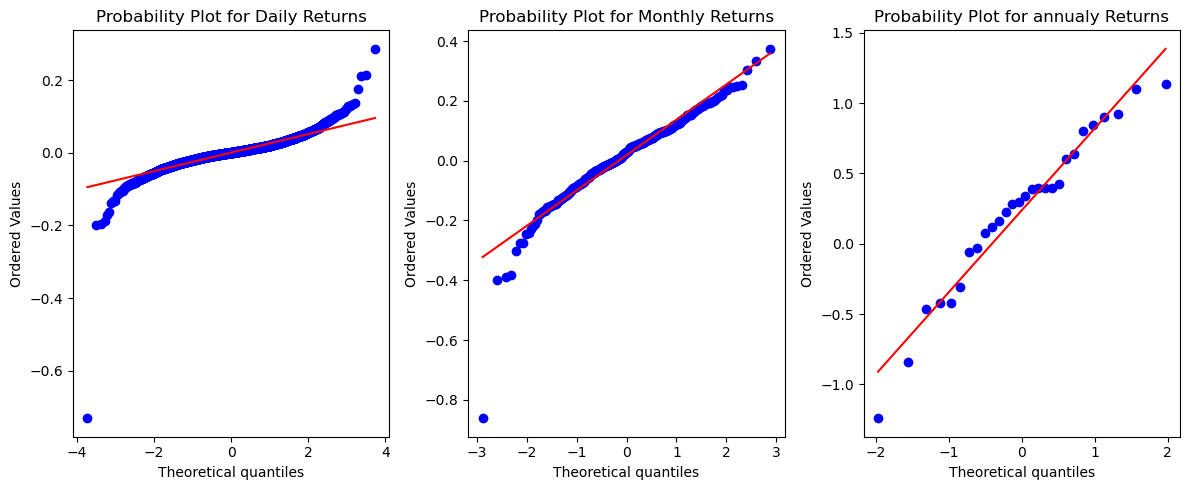

In [123]:
#QQ-plot (Normal distribution)
# Set up the subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

# Probability Plot for Daily Returns
stats.probplot(rt_d, dist="norm", plot=axs[0])
axs[0].set_title("Probability Plot for Daily Returns")
#long left tail long right tail

# Probability Plot for Monthly Returns
stats.probplot(rt_m, dist="norm", plot=axs[1])
axs[1].set_title("Probability Plot for Monthly Returns")

# Probability Plot for Yearly Returns
stats.probplot(rt_y, dist="norm", plot=axs[2])
axs[2].set_title("Probability Plot for annualy Returns")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [225]:
#CAPM
#Risk free
RF=0.05
#We us S&P500 as market risk premium
SP500 = yf.download('^GSPC', start, end)
#We look at the closing prices
MSP500= SP500.resample('M').last()
SP500_adj = MSP500["Adj Close"]
#S&P500 monthly excess returns
RSP500 = SP500_adj.pct_change().dropna()
RSP500= RSP500-RF
RSP500

[*********************100%%**********************]  1 of 1 completed


Date
1995-02-28   -0.013926
1995-03-31   -0.022671
1995-04-30   -0.022040
1995-05-31   -0.013688
1995-06-30   -0.028721
                ...   
2023-08-31   -0.067716
2023-09-30   -0.098719
2023-10-31   -0.071980
2023-11-30    0.039179
2023-12-31   -0.005771
Freq: M, Name: Adj Close, Length: 347, dtype: float64

In [226]:
#We calculate the monthly excess returns of Apple
Pt_m=Pt_d.resample('M').last()
R = Pt_m.pct_change().dropna()- RF
R

Date
1995-02-28   -0.068981
1995-03-31   -0.157597
1995-04-30    0.035108
1995-05-31    0.039615
1995-06-30    0.067294
                ...   
2023-08-31   -0.092384
2023-09-30   -0.138678
2023-10-31   -0.052570
2023-11-30    0.063780
2023-12-31   -0.036417
Freq: M, Name: Adj Close, Length: 347, dtype: float64

Slope :  [[1.18035942]]
Ordinate at origin :  [0.02754906]
Root mean square error :  0.010284682579457659
Score R2 :  0.2088600801810534


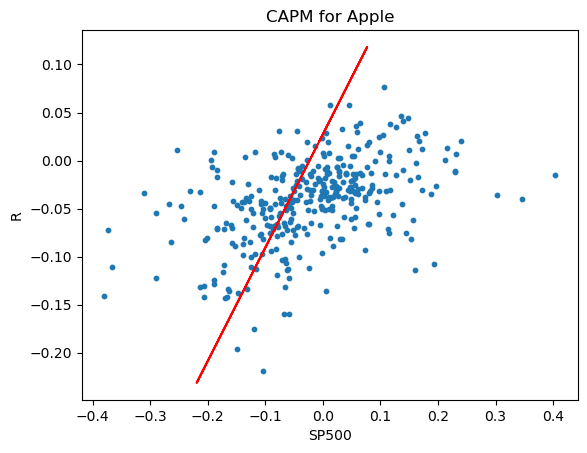

In [231]:
#We ar searching B to have R= B*RSP500
#We are going to do a linear regrssion
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
#We delete extrem values

        
RSP500 = np.array(RSP500).reshape(-1, 1)
R = np.array(R).reshape(-1, 1)

regression_model = LinearRegression()
regression_model.fit(RSP500, R)
R_predicted = regression_model.predict(RSP500)
# Model evalution
rmse = mean_squared_error(R, R_predicted)
r2 = r2_score(R, R_predicted)
#Linear regression's data
print("Slope : " ,regression_model.coef_)
print("Ordinate at origin : ", regression_model.intercept_)
print("Root mean square error : ", rmse)
print('Score R2 : ', r2)
#Data plot
plt.scatter(R, RSP500, s=10)
plt.xlabel('SP500')
plt.ylabel('R')
plt.title('CAPM for Apple')
# Predicted Dara
plt.plot(RSP500, R_predicted, color='r')
plt.show()
